In [1]:
### Global
import numpy as np

from scipy.interpolate import interp1d
from scipy.integrate import simps
from chainconsumer import ChainConsumer

import matplotlib.pyplot as plt

### Local
from utilities import *

### For plotting
import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rcParams.update({'axes.labelsize': 20, 'legend.fontsize': 20 })

In [2]:
### GW150914 parameters 
### Are these the masses in detector's frame???
m1   = 36       #solarmass
m2   = 29

Dl   = 410      #Mpc
zem  = 0.09

yr_s = 365 *24 *3600 
t_yr = 2.
time = t_yr *yr_s # time before merger in sec
tc   = 0
psic = 0

In [3]:
#Read in and interpolate LIGO and LISA PSDs.
path_to_data = '../../data/'

ligo_data    = np.genfromtxt(path_to_data 
                +'lalsimulation_lib_LIGO-T1800545-v1-aLIGO_175Mpc.txt')
LISA_strain  = np.loadtxt(path_to_data+'LISA_strain.txt')

ligo_interp  = interp1d(ligo_data[:,0], ligo_data[:,1])
lisa_interp  = interp1d(LISA_strain[:,0], LISA_strain[:,3])

fligo   = np.logspace(np.log10(ligo_data[0,0]), np.log10(ligo_data[-1,0]), 1000)
flisa   = np.logspace(np.log10(LISA_strain[0,0]), np.log10(LISA_strain[-1,0]), 1000)

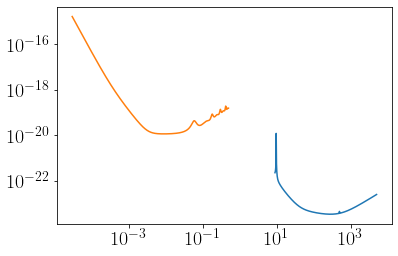

In [4]:
plt.loglog(fligo, ligo_interp(fligo))
plt.loglog(flisa, np.sqrt(lisa_interp(flisa)) ) ;

In [5]:
### Get dL
Dl_s   = Dl *Mpc/c        # Dl in sec

### Get mass quantities (are these in source or detector frame???)
m_eff  = m1*m2/(m1+m2)
Ms     = m_eff**(3./5) * (m1+m2)**(2./5)     # chirp mass in solarmass
eta    = ((m1+m2)/Ms)**(-5./3)
Ms_s   = Ms * Msolar * GN / (c*1.e3)**3.       # chirp mass in sec
Mtot_s = (m1+m2) * Msolar * GN / (c*1.e3)**3.


### Get frequency ranges for inspiral and plots
# starting frequency at the time before merger
f_start = (5 *Ms_s /256 /time)**(3./8) /np.pi /Ms_s      
# End of IMR template
f_cut   = get_freq(Mtot_s, eta, "cut") 

#### NB!!!!! inspiral_fc wants redshifted total mass why is this source?
fc      = inspiral_fc(Mtot_s)
farr    = np.logspace(np.log10(f_start), np.log10(fc),num=500)     # inspiral range only
f_plot  = np.logspace(np.log10(f_start), np.log10(f_cut),num=500)  # full IMR waveform
Dl_arr  = np.array([Dl_s]*len(farr))

In [6]:
#Waveforms for inspiral and IMR, in GR
pars_GR = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 0, 0]
h_GR    = waveform(farr, pars_GR)
h_plot  = waveform(f_plot, pars_GR)

In [7]:
# Get waveform segments in LISA and LIGO ranges only.
farr_ligo = np.logspace(np.log10(ligo_data[0,0]), np.log10(fc),num=500)
farr_lisa = np.logspace(np.log10(f_start),np.log10(LISA_strain[-1,0]),num=500)

ligo_psd  = ligo_interp(farr_ligo)**2
lisa_psd  = lisa_interp(farr_lisa)

h_GR_ligo = waveform(farr_ligo, pars_GR)
h_GR_lisa = waveform(farr_lisa, pars_GR)

# GR Constraints

In [8]:
ders_ligo         = Fisher_der(farr_ligo, pars_GR, which_wf='GR', dist_corr=True)
fisher_ligo       = Fisher_build(farr_ligo, ligo_psd, ders_ligo)
cov_matrix_ligo   = np.linalg.inv(fisher_ligo)
pconstraints_ligo = np.sqrt(np.diag(cov_matrix_ligo))

print('\nLIGO conditioning')
print(np.linalg.cond(fisher_ligo))
print('\nLIGO GR constraints')
print(pconstraints_ligo)

- Working on index 0
Ratio best = 2.80e-14 for dx = 3.34e-01
Ratio best = 5.74e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 2.51e-03 for dx = 1.40e-01
- Working on index 2
- Working on index 3
- Working on index 4
- Working on index 5
This took 3.08 seconds

LIGO conditioning
13549781.984566242

LIGO GR constraints
[0.01955086 0.00265629 0.01541939 0.00056156 0.20065686]


In [9]:
ders_lisa         = Fisher_der(farr_lisa, pars_GR, which_wf='GR', dist_corr=True)
fisher_lisa       = Fisher_build(farr_lisa, lisa_psd, ders_lisa)
cov_matrix_lisa   = np.linalg.inv(fisher_lisa)
pconstraints_lisa = np.sqrt(np.diag(cov_matrix_lisa))

print('\nLISA conditioning')
print(np.linalg.cond(fisher_lisa))
print('\nLISA GR constraints')
print(pconstraints_lisa)

- Working on index 0
Ratio best = 1.70e-14 for dx = 3.34e-01
Ratio best = 5.67e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 3.48e-03 for dx = 1.40e-01
- Working on index 2
- Working on index 3
- Working on index 4
- Working on index 5
This took 3.07 seconds

LISA conditioning
1.031337030214424e+16

LISA GR constraints
[4.84935774e-02 7.36530208e-06 2.91331816e-01 3.65767845e+00
 4.49602444e+00]


In [10]:
feval, fevecs = np.linalg.eigh(fisher_lisa)

cov_matrix_lisa = np.linalg.inv(fisher_lisa)
pconstraints_lisa = np.sqrt(np.diag(cov_matrix_lisa))

print('\nLISA GR constraints')
print(feval, '\n')
print(fevecs[:,0])
print(fevecs[:,-1], '\n')
print(pconstraints_lisa)


LISA GR constraints
[4.00827081e-02 1.15628218e-01 1.17821397e+01 1.03876678e+04
 4.13410283e+14] 

[ 7.14133585e-03 -1.10781147e-06 -9.26327584e-07  5.38712642e-01
  8.42459311e-01]
[ 1.38646250e-04  9.99999990e-01 -2.37498923e-14 -2.81746164e-08
  1.57716878e-07] 

[4.84935774e-02 7.36530208e-06 2.91331816e-01 3.65767845e+00
 4.49602444e+00]


In [11]:
fisher_tot = fisher_ligo +fisher_lisa

cov_tot = np.linalg.inv(fisher_tot)
c_tot   = np.sqrt(np.diag(cov_tot))

print('\n Conditioning tot (units of 1e15)')
print(np.linalg.cond(fisher_tot) / 1e15)
print('\nLISA GR constraints')
print(c_tot)


 Conditioning tot (units of 1e15)
0.005185653968004333

LISA GR constraints
[4.35555386e-03 6.21888733e-07 1.52387816e-02 3.37535769e-04
 1.11927876e-01]


In [12]:
label_GR = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$']
fid_vals_GR = [0,0,0,0,0]

data_ligo = np.random.multivariate_normal(fid_vals_GR, cov_matrix_ligo, size=10000)
data_lisa = np.random.multivariate_normal(fid_vals_GR, cov_matrix_lisa, size=10000)
data_cross = np.random.multivariate_normal(fid_vals_GR, cov_tot, size=10000)

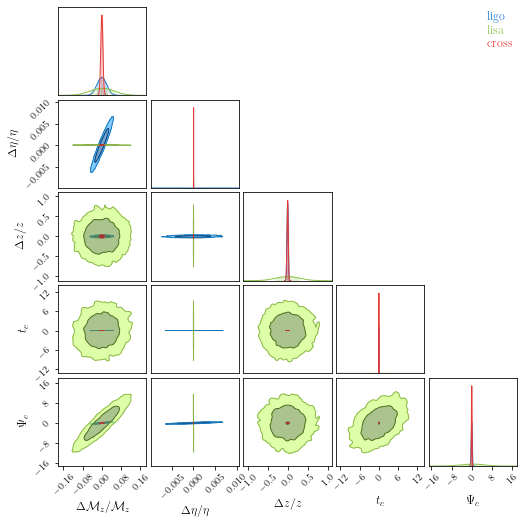

In [13]:
cc = ChainConsumer()
cc.add_chain(data_ligo, bins=30, smooth=True, parameters=label_GR, name='ligo');
cc.add_chain(data_lisa, bins=30, smooth=True, parameters=label_GR, name='lisa');
cc.add_chain(data_cross, bins=30, smooth=True, parameters=label_GR, name='cross');
cc.plotter.plot();

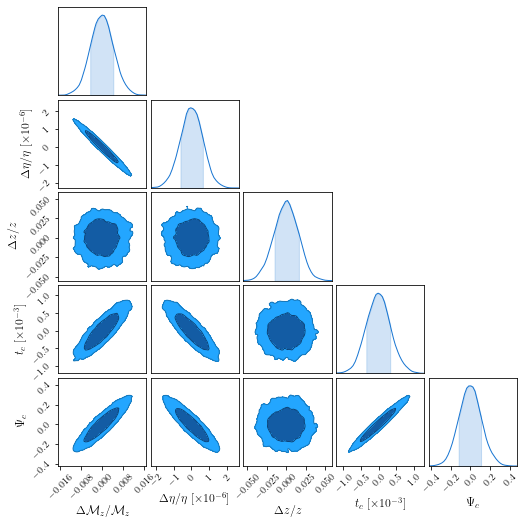

In [14]:
cc = ChainConsumer()
cc.add_chain(data_cross, bins=30, smooth=True, parameters=label_GR, name='cross');
cc.plotter.plot();

# Step function

In [15]:
# Set parameters for step
fstar = 0.8
c0    = 0.9
w1    = 0.1

In [16]:
# Evaluate and plot Delta
cT_step_fo_w1 = cT_step(farr, fstar, c0, w1)
cT_step_fs_w1 = cT_step(farr*(1+zem), fstar, c0, w1)
Delta_step_w1 = 1-cT_step_fo_w1/cT_step_fs_w1

In [17]:
# Set parameters for runs and evaluate
pars_step     = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, c0, fstar]
pars_step_fid = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 1., fstar]

### LIGO
h_Delta_step_w1_ligo     = h_Delta_inspiral(farr_ligo, pars_step, width=w1, cT_type='step')
h_Delta_step_w1_fid_ligo = h_Delta_inspiral(farr_ligo, pars_step_fid, width=w1, cT_type='step')

### LISA
h_Delta_step_w1     = h_Delta_inspiral(farr_lisa, pars_step, width=w1, cT_type='step')
h_Delta_step_w1_fid = h_Delta_inspiral(farr_lisa, pars_step_fid, width=w1, cT_type='step')
h_Delta_step_w1_fid_nodist = h_Delta_inspiral(farr_lisa, pars_step_fid, width=w1, cT_type='step', dist_corr=False)

# For plotting only
h_Delta_step_w1_plot = h_Delta_inspiral(farr, pars_step, width=w1, cT_type='step')

/home/mauropieroni/Media/HD1/My_projects/multiband_MG/code/New_version/utilities.py:139: RuntimeWarning: divide by zero encountered in divide
  x = np.clip((x - x_min) / (x_max - x_min), 0, 1)


In [18]:
# Derivative for LISA
ders_lisa_step = Fisher_der(farr_lisa, pars_step, which_wf='step', MG_flag=True, width=w1, dist_corr=False)

- Working on index 0
Ratio best = 1.65e-14 for dx = 3.34e-01
Ratio best = 5.67e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 3.48e-03 for dx = 1.40e-01
- Working on index 2
- Working on index 3
- Working on index 4
- Working on index 5
Ratio best = 1.49e-03 for dx = 9.00e-02
This took 2.54 seconds


In [19]:
# Build Fisher for LISA
fisher_lisa_step     = Fisher_build(farr_lisa, lisa_psd, ders_lisa_step)

eval_lisa, evec_lisa = np.linalg.eigh(fisher_lisa_step)
fisher_lisa_step     += 1e-15 *np.max(eval_lisa)

print('LISA step function conditioning (units 1e15)')
print(np.linalg.cond(fisher_lisa_step)/1e15)

cov_matrix_lisa_step = np.linalg.inv(fisher_lisa_step)
pconstraints_lisa_step = np.sqrt(np.diag(cov_matrix_lisa_step))

print('\nLISA step function')
print(pconstraints_lisa_step)

LISA step function conditioning (units 1e15)
3856.01585223989

LISA step function
[4.36442196e-02 6.62877187e-06 6.45191176e+01 3.29191061e+00
 4.04642200e+00 5.80811376e+01]


In [20]:
# Derivative for LIGO
ders_ligo_step = Fisher_der(farr_ligo, pars_step, which_wf='step', MG_flag=True, width=w1, dist_corr=False)

- Working on index 0
Ratio best = 2.80e-14 for dx = 3.34e-01
Ratio best = 5.74e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 2.51e-03 for dx = 1.40e-01
- Working on index 2
- Working on index 3
- Working on index 4
- Working on index 5
This took 2.79 seconds


In [21]:
# Build Fisher for LIGO
fisher_ligo_step     = Fisher_build(farr_ligo, ligo_psd, ders_ligo_step) 
eval_ligo, evec_ligo = np.linalg.eigh(fisher_ligo_step)
fisher_ligo_step     += 1e-15 *np.max(eval_ligo)

print('LIGO step function conditioning (units 1e15)')
print(np.linalg.cond(fisher_ligo_step)/1e15)

cov_matrix_ligo_step = np.linalg.inv(fisher_ligo_step)
pconstraints_ligo_step = np.sqrt(np.diag(cov_matrix_ligo_step))

print('\nLIGO step function')
print(pconstraints_ligo_step)

LIGO step function conditioning (units 1e15)
1.0000000167291143

LIGO step function
[1.95508597e-02 2.65629294e-03 1.54193872e-02 5.61555313e-04
 2.00656859e-01 1.73085134e+03]


In [22]:
fisher_tot = fisher_ligo_step +fisher_lisa_step
evals, evecs = np.linalg.eigh(fisher_tot)
print(evals)
### NO PROBLEM WITH THE CONDITIONING HERE!!!

[1.83960778e+01 8.16335234e+01 4.30959161e+03 3.02767783e+05
 3.33166996e+08 5.10383073e+14]


In [23]:
### NOW PLUG BACK DIST CORR and recompute derivatives for LISA!!!
ders_lisa_step_corr = Fisher_der(farr_lisa, pars_step, which_wf='step', MG_flag=True, width=w1, dist_corr=True)

- Working on index 0
Ratio best = 1.65e-14 for dx = 3.34e-01
Ratio best = 5.67e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 3.48e-03 for dx = 1.40e-01
- Working on index 2
- Working on index 3
- Working on index 4
- Working on index 5
Ratio best = 1.49e-03 for dx = 9.00e-02
Ratio best = 9.15e-16 for dx = 9.00e-02
This took 4.94 seconds


In [24]:
### Recompute fisher for LISA!!!
fisher_lisa_step_corr = Fisher_build(farr_lisa, lisa_psd, ders_lisa_step_corr)

In [25]:
### recompute derivatives for LIGO!!!
ders_ligo_step_corr = Fisher_der(farr_ligo, pars_step, which_wf='step', MG_flag=True, width=w1, dist_corr=True)

- Working on index 0
Ratio best = 2.80e-14 for dx = 3.34e-01
Ratio best = 5.74e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 2.51e-03 for dx = 1.40e-01
- Working on index 2
- Working on index 3
- Working on index 4
- Working on index 5
This took 3.16 seconds


In [26]:
### Recompute fisher for LIGO!!!
fisher_ligo_step_corr = Fisher_build(farr_ligo, ligo_psd, ders_ligo_step_corr)

In [35]:
simps(np.abs(ders_lisa_step_corr)**2, x=farr_lisa, axis=-1) / simps(np.abs(ders_lisa_step_corr[0,:])**2, x=farr_lisa, axis=-1) 

array([1.00000000e+00, 5.31098134e+07, 6.75627081e+26, 6.75554802e-07,
       2.43323265e-06, 8.02712535e+28])

In [27]:
fisher_tot_corr = fisher_ligo_step_corr +fisher_lisa_step_corr
evals, evecs = np.linalg.eigh(fisher_tot_corr)
print(evals)

[-2.00996961e+18 -3.97810246e+05  7.32100871e+02  3.33166832e+08
  7.40675541e+19  5.13730205e+35]


In [78]:
### Reducing magnitude of dh/dlneta and computing new fisher
new_ligo = np.array(ders_ligo_step_corr)
new_lisa = np.array(ders_lisa_step_corr)

mat       = np.eye(len(new_ligo))
mat[1,1]  = 1e-5
mat[2,2]  = 1e-10
mat[-1,-1] = 1e-11

new_lisa = np.matmul(mat, new_lisa)
new_ligo = np.matmul(mat, new_ligo)

fisher_lisa_step_corr  = Fisher_build(farr_lisa, lisa_psd, new_lisa)
fisher_ligo_step_corr  = Fisher_build(farr_ligo, ligo_psd, new_ligo)

cross_corr = fisher_lisa_step_corr +fisher_ligo_step_corr
print(np.linalg.cond(cross_corr)/1e15)

evals, evecs = np.linalg.eigh(cross_corr)
print('\n', evals, '\n')
print('Smallest:', evecs[:,0])
print('Second largest:', evecs[:,-2])
print('Largest:', evecs[:,-1])

20.57980976800805

 [5.68415179e-03 5.64190530e+01 1.35993414e+03 1.66120126e+06
 3.33167155e+08 9.38229833e+13] 

Smallest: [-1.73049490e-08  2.72265581e-07  7.36873460e-01 -1.15052286e-09
 -4.00357170e-07  6.76030697e-01]
Second largest: [ 1.21356768e-02  2.91804406e-06 -2.40653450e-06  9.99920593e-01
 -3.39607909e-03  2.62312260e-06]
Largest: [ 3.00220909e-04  2.19343446e-05  6.76030667e-01 -8.23172332e-08
  3.93625248e-07 -7.36873427e-01]


In [68]:
fisher_lisa_step_corr_noc0  = Fisher_build(farr_lisa, lisa_psd, new_lisa[:-1])
fisher_ligo_step_corr_noc0  = Fisher_build(farr_ligo, ligo_psd, new_ligo[:-1])

cross_corr_noc0 = fisher_lisa_step_corr_noc0 +fisher_ligo_step_corr_noc0
print(np.linalg.cond(cross_corr_noc0)/1e15)

0.0007600604116412848


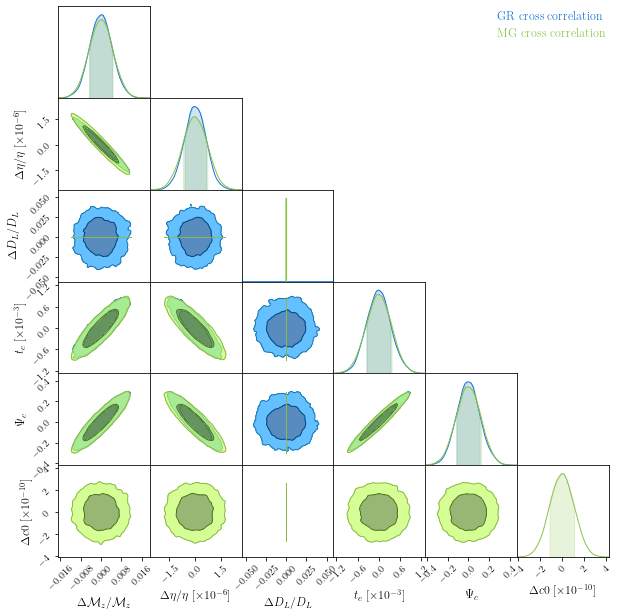

In [76]:
fid_vals = [0,0,0,0,0,0]
label    = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta D_L/D_L$', 
                r'$t_c$',r'$\Psi_c$', r'$\Delta c0$']

cov_mat_cross = np.matmul(np.matmul(mat, np.linalg.inv(cross_corr)), mat)
data_distcorr = np.random.multivariate_normal(fid_vals, cov_mat_cross, size=20000)

cc = ChainConsumer()

cc.add_chain(data_cross, bins=30, smooth=True, parameters=label[:-1], name='GR cross correlation');
cc.add_chain(data_distcorr, bins=30, smooth=True, parameters=label, name='MG cross correlation');
cc.plotter.plot();

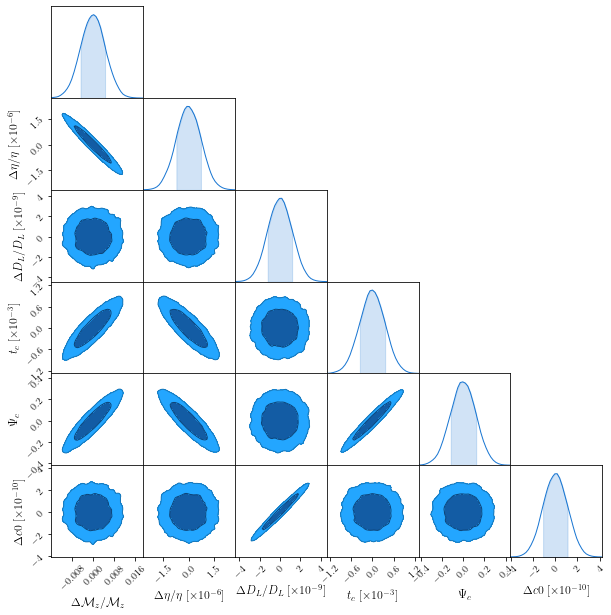

In [79]:
cc = ChainConsumer()

cc.add_chain(data_distcorr, bins=30, smooth=True, parameters=label, name='MG cross correlation');
cc.plotter.plot();

In [ ]:
# MG LISA Fisher matrix for GR parameters with dist corr
mat_noc0 = mat[:-1,:-1]

cov_mat_cross_noc0 = np.matmul(np.matmul(mat_noc0, np.linalg.inv(cross_corr_noc0)), mat_noc0)

data_distcorr_noc0 = np.random.multivariate_normal(fid_vals_MG[:-1], cov_mat_cross_noc0, size=20000)

cc = ChainConsumer()

cc.add_chain(data_distcorr_noc0, bins=30, smooth=True, parameters=label[:-1], name='MG cross correlation no c0');
cc.add_chain(data_distcorr, bins=30, smooth=True, parameters=label, name='MG cross correlation');
cc.plotter.plot();

In [ ]:
new_ligo_nodist = np.array(ders_ligo_step[:-1])
new_lisa_nodist = np.array(ders_lisa_step[:-1])

mat_nodist        = np.identity(len(new_ligo_nodist))
mat_nodist[1,1]   = 1e-5

new_lisa_nodist = np.matmul(mat_nodist, new_lisa_nodist)
new_ligo_nodist = np.matmul(mat_nodist, new_ligo_nodist)

fisher_lisa_step  = Fisher_build(farr_lisa, lisa_psd, new_lisa_nodist)
fisher_ligo_step  = Fisher_build(farr_ligo, ligo_psd, new_ligo_nodist)

cross_nodist = fisher_lisa_step +fisher_ligo_step

cov_mat_cross_nodist = np.matmul(np.matmul(mat_nodist, np.linalg.inv(cross_nodist)), mat_nodist)

print(np.linalg.cond(cross_nodist)/1e15)

In [ ]:
new_ligo_nodist_c0 = np.array(ders_ligo_step)
new_lisa_nodist_c0 = np.array(ders_lisa_step)

mat_nodist_c0        = np.identity(len(new_ligo_nodist_c0))
mat_nodist_c0[1,1]   = 1e-5

new_lisa_nodist_c0 = np.matmul(mat_nodist_c0, new_lisa_nodist_c0)
new_ligo_nodist_c0 = np.matmul(mat_nodist_c0, new_ligo_nodist_c0)

fisher_lisa_step_c0  = Fisher_build(farr_lisa, lisa_psd, new_lisa_nodist_c0)
fisher_ligo_step_c0  = Fisher_build(farr_ligo, ligo_psd, new_ligo_nodist_c0)

cross_nodist_c0 = fisher_lisa_step_c0 +fisher_ligo_step_c0

cov_mat_cross_nodist_c0 = np.matmul(np.matmul(mat_nodist_c0, np.linalg.inv(cross_nodist_c0)), mat_nodist_c0)

print(np.linalg.cond(cross_nodist_c0)/1e15)

In [ ]:
constraint_GR = np.zeros(5)
constraint_MG_nodist = np.zeros(5)
constraint_MG_nodist_c0 = np.zeros(6)
constraint_MG_noc0 = np.zeros(5)
constraint_MG = np.zeros(6)

for i in range(5):
    constraint_GR[i] = cov_sum[i,i]
    constraint_MG_nodist[i] = cov_mat_cross_nodist[i,i]
    constraint_MG_noc0[i] = cov_mat_cross_noc0[i,i]

for i in range(6):
    constraint_MG[i] = cov_mat_cross[i,i]
    constraint_MG_nodist_c0[i] = cov_mat_cross_nodist_c0[i,i]

print('GR')
print(constraint_GR)
print('\nno dist corr no c0')
print(constraint_MG_nodist)
print('\nno dist corr with c0')
print(constraint_MG_nodist_c0)
print('\nwith dist corr no c0')
print(constraint_MG_noc0)
print('\nwith dist corr with c0')
print(constraint_MG)